In [ ]:
import os
import torch
import torch
from torchvision import transforms
from transformers import BertTokenizer
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

ROOT = f"{os.getcwd()}/pmc_dataset/process"
MODEL_DIR = f"{ROOT}/log/checkpoint.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.chdir(ROOT)

In [ ]:
import yaml
import torch
from skimage import io
import numpy as np
import cv2
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import os
from tqdm import tqdm
import json

from subfigure_ocr.models.yolov3 import *
from subfigure_ocr.models.network import *
from subfigure_ocr.separator import process

In [ ]:
class classifier():
    def __init__(self):
        self.root = '/fs01/home/afallah/Multimodal/pmc_dataset/process/subfigure_ocr/'
        configuration_file = self.root + "config/yolov3_default_subfig.cfg"
        with open(configuration_file, 'r') as f:
            configuration = yaml.load(f, Loader=yaml.FullLoader)

        self.image_size            = configuration['TEST']['IMGSIZE']
        self.nms_threshold         = configuration['TEST']['NMSTHRE']
        self.confidence_threshold  = 0.0001
        self.dtype = torch.cuda.FloatTensor
        self.device = torch.device('cuda')

        object_detection_model = YOLOv3(configuration['MODEL'])
        self.object_detection_model = self.load_model_from_checkpoint(object_detection_model, "object_detection_model.pt")
        ## Load text recognition model
        text_recognition_model = resnet152()
        self.text_recognition_model = self.load_model_from_checkpoint(text_recognition_model, 'text_recognition_model.pt')

        self.object_detection_model.eval()
        self.text_recognition_model.eval()

    def load_model_from_checkpoint(self, model, model_name):
        """ load checkpoint weights into model """
        checkpoints_path = self.root + "checkpoints/"
        checkpoint = checkpoints_path + model_name
        model.load_state_dict(torch.load(checkpoint))
        # model = nn.DataParallel(model)
        model.to(self.device)
        return model
    
    def detect_subfigure_boundaries(self, figure_path):
        """ Detects the bounding boxes of subfigures in figure_path

        Args:
            figure_path: A string, path to an image of a figure
                from a scientific journal
        Returns:
            subfigure_info (list of lists): Each inner list is
                x1, y1, x2, y2, confidence 
        """

        ## Preprocess the figure for the models
        img = io.imread(figure_path)
        if len(np.shape(img)) == 2:
            img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        else:
            img = cv2.cvtColor(img,cv2.COLOR_RGBA2RGB)

        img, info_img = process.preprocess(img, self.image_size, jitter=0)
        img = np.transpose(img / 255., (2, 0, 1))
        img = np.copy(img)
        img = torch.from_numpy(img).float().unsqueeze(0)
        img = Variable(img.type(self.dtype))

        img_raw = Image.open(figure_path).convert("RGB")
        width, height = img_raw.size

        ## Run model on figure
        with torch.no_grad():
            outputs = self.object_detection_model(img.to(self.device))
            outputs = process.postprocess(outputs, dtype=self.dtype, 
                        conf_thre=self.confidence_threshold, nms_thre=self.nms_threshold)

        ## Reformat model outputs to display bounding boxes in our desired format
        ## List of lists where each inner list is [x1, y1, x2, y2, confidence]
        subfigure_info = list()

        if outputs[0] is None:
            return subfigure_info

        for x1, y1, x2, y2, conf, cls_conf, cls_pred in outputs[0]:
            box = process.yolobox2label([y1.data.cpu().numpy(), x1.data.cpu().numpy(), y2.data.cpu().numpy(), x2.data.cpu().numpy()], info_img)
            box[0] = int(min(max(box[0],0),width-1))
            box[1] = int(min(max(box[1],0),height-1))
            box[2] = int(min(max(box[2],0),width))
            box[3] = int(min(max(box[3],0),height))
            # ensures no extremely small (likely incorrect) boxes are counted
            small_box_threshold = 5
            if (box[2]-box[0] > small_box_threshold and 
                box[3]-box[1] > small_box_threshold):
                box.append("%.3f"%(cls_conf.item()))
                subfigure_info.append(box)
        return subfigure_info

    def detect_subfigure_labels(self, figure_path, subfigure_info):
        """ Uses text recognition to read subfigure labels from figure_path
        
        Note: 
            To get sensible results, should be run only after
            detect_subfigure_boundaries has been run
        Args:
            figure_path (str): A path to the image (.png, .jpg, or .gif)
                file containing the article figure
            subfigure_info (list of lists): Details about bounding boxes
                of each subfigure from detect_subfigure_boundaries(). Each
                inner list has format [x1, y1, x2, y2, confidence] where
                x1, y1 are upper left bounding box coordinates as ints, 
                x2, y2, are lower right, and confidence the models confidence
        Returns:
            subfigure_info (list of tuples): Details about bounding boxes and 
                labels of each subfigure in figure. Tuples for each subfigure are
                (x1, y1, x2, y2, label) where x1, y1 are upper left x and y coord
                divided by image width/height and label is the an integer n 
                meaning the label is the nth letter
            concate_img (np.ndarray): A numpy array representing the figure.
                Used in classify_subfigures. Ideally this will be removed to 
                increase modularity. 
        """
        img_raw = Image.open(figure_path).convert("RGB")
        img_raw = img_raw.copy()
        width, height = img_raw.size
        binary_img = np.zeros((height,width,1))

        detected_label_and_bbox = None
        max_confidence = 0.0
        for subfigure in subfigure_info:
            ## Preprocess the image for the model
            bbox = tuple(subfigure[:4])
            img_patch = img_raw.crop(bbox)
            img_patch = np.array(img_patch)[:,:,::-1]
            img_patch, _ = process.preprocess(img_patch, 28, jitter=0)
            img_patch = np.transpose(img_patch / 255., (2, 0, 1))
            img_patch = torch.from_numpy(img_patch).type(self.dtype).unsqueeze(0)

            ## Run model on figure
            label_prediction = self.text_recognition_model(img_patch.to(self.device))
            label_confidence = np.amax(F.softmax(label_prediction, dim=1).data.cpu().numpy())
            x1,y1,x2,y2, box_confidence = subfigure
            total_confidence = float(box_confidence)*label_confidence
            if total_confidence < max_confidence:
                continue
            label_value = chr(label_prediction.argmax(dim=1).data.cpu().numpy()[0]+ord("a"))
            if label_value == "z":
                continue
            if (x2-x1) < 64 and (y2-y1)< 64:
                detected_label_and_bbox = [label_value, x1,y1,x2,y2]
        
        return detected_label_and_bbox
    
    def run(self, figure_path):
        subfigure_info = self.detect_subfigure_boundaries(figure_path)
        subfigure_info = self.detect_subfigure_labels(figure_path, subfigure_info)      

        return subfigure_info

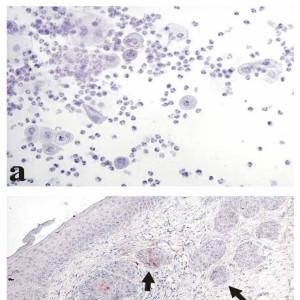

Cropped image dimensions: (300, 300)


In [61]:
from PIL import Image
from IPython.display import display, Image as IPImage

# Load and crop image
image_path = "/datasets/PMC-15M/figures/PMC517716_F1.jpg/1471-2407-4-58-1.jpg"
img = Image.open(image_path)
crop_box = (0, 0, 300, 300)  # (left, top, right, bottom)
cropped_img = img.crop(crop_box)

# Save cropped image temporarily
crop_path = "cropped_image.jpg"
cropped_img.save(crop_path)

# Display cropped image
display(IPImage(filename=crop_path, width=400))  # Adjust width as needed
print(f"Cropped image dimensions: {cropped_img.size}")

In [ ]:
# Process with model
model = classifier()

In [62]:
results = model.run(crop_path)
print("Model results:", results)

# Clean up
import os
os.remove(crop_path)
print("Temporary file removed")

Model results: ['a', 11, 164, 24, 184]
Temporary file removed
